In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from src.functions import *
from src.params import *
from omegaconf import OmegaConf
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In models folder, there are two python files, sm_models and sm_models_d.

The first one contains the solution based on the PINNSIM/ Ignasi's model, while the second is based on the Power Dynamics formulation. Their major difference is the value of damping torque. According to Sauer and Pi book p.105, where 5.157 is followed by Power Dynamics and 5.158 is used for the other solution. As a result the value of D should be altered accordingly.

Check also p.130 and p.131 3.203 eq. Kundur where instead of altering D, the divide omega-omega_B by omega_B,
and also p.730 eq 12.78 for the formulation that matches PINNSIM.

p.190 8.25 equation and p.223 eq. 9.8


The third book: p.375 PSS

Two models were implemented, Power Dynamics and PINNSIM

In [2]:
from src.ode.sm_models import SynchronousMachineModels

Specify all the parameters of the models and also the initial values for AVR and GOV

In [3]:
def return_params(model_number, modeling_flag):
    "Synchronous machine parameters"
    #H0 , X_d0, X_d_dash0, X_q0, X_q_dash0, T_d_dash0, T_q_dash0, D0, Rs0, P_m0, E_fd0 = matrix.loc[model_number]
    D0  = 2.364
    E_fd0 = 1.08
    H0 = 23.64
    P_m0 =  0.71
    Rs0= 0
    T_d_dash0= 8.96
    T_q_dash0= 0.31
    X_d_dash0= 0.0608
    X_q_dash0= 0.0969
    X_d0= 0.146
    X_q0= 0.0969

    if model_number == 3:
        P_m0 = 1 #
    if model_number == 0:
        D0 = 2.364 #Following Ignasi's parameter, because original value was quite small and converged slowly
    "AVR parameters from IEEE 14 bus system/ power dynamics"
    K_A0=20
    T_A0=0.2
    K_E0=1.0
    T_E0=0.314
    K_F0=0.063
    T_F0=0.35



    "V_ref SOSOS following page 190 Sauer and Pi is calculated within the model class"
    V_ref0=1.095
    "GOV parameters from Power Dynamics and Sauer and Pi p.86"
    P_c = 0.7
    R_d = 0.05
    T_ch = 0.4 
    T_sv = 0.2
    "system parameters following good practice"
    omega_B0=314.1592653589793
    Vs0=1
    theta_vs0=0

    "return parameters for the various models"
    if modeling_flag == "SM":
        return [X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, P_m0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, E_fd0]
    
    
    if modeling_flag == "SM_AVR":
        return [X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, P_m0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, E_fd0, K_A0, T_A0, K_E0, T_E0, K_F0, T_F0, V_ref0]
    if modeling_flag == "SM_AVR_GOV":
        return [X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, P_m0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, E_fd0, K_A0, T_A0, K_E0, T_E0, K_F0, T_F0, V_ref0, P_c, R_d, T_ch, T_sv]                
    return [X_d_dash0, X_q_dash0, Vs0, theta_vs0, omega_B0, H0, P_m0, D0, T_q_dash0, X_q0, T_d_dash0, X_d0, Rs0, E_fd0]
    
def return_initial_conditions(model_number, delta, omega, E_d_dash, E_q_dash, modeling_flag):

    'Initial values'
    "Infinite bus and 2 axis model initial conditions"
    delta0=delta
    omega0=omega
    E_d_dash0=E_d_dash
    E_q_dash0=E_q_dash
    
    if modeling_flag == "SM" or modeling_flag == "SM_IB":
        return [delta0, omega0, E_d_dash0, E_q_dash0]
    
    "AVR initial conditions"
    V_r0=1.105
    R_F0= 1

    "AVR parameters from IEEE 14 bus system/ power dynamics"
    K_A0=20
    T_A0=0.2
    K_E0=1.0
    T_E0=0.314
    K_F0=0.063
    T_F0=0.35

    "calculated following Sauer and Pi p.190 example"
    "using the initial conditions from above for the current calculation"
    #H0 , X_d0, X_d_dash0, X_q0, X_q_dash0, T_d_dash0, T_q_dash0, D0, Rs0, P_m0, E_fd0 = matrix.loc[model_number]
    D0  = 20.364
    E_fd0 = 1.08
    H0 = 23.64
    P_m0 =  0.71
    Rs0= 0
    T_d_dash0= 8.96
    T_q_dash0= 0.31
    X_d_dash0= 0.0608
    X_q_dash0= 0.0969
    X_d0= 0.146
    X_q0= 0.0969
    theta_vs0=0
    Vs0=1
    I_d, I_q = calculate_current (theta_vs0, E_d_dash0, E_q_dash0, X_d_dash0, X_q_dash0, Rs0, Vs0, theta_vs0)

    E_fd0=E_q_dash0 + (X_d0 - X_d_dash0) * I_d
    R_F0=K_F0/T_F0*E_fd0
    V_r0=(K_E0 +0.098 * np.e**(E_fd0*0.55)) * E_fd0
    
    if modeling_flag == "SM_AVR":
        return [delta0, omega0, E_d_dash0, E_q_dash0, R_F0, V_r0, E_fd0]
    
    "GOV initial conditions"
    P_sv0 = 0.7048 # solving p.86 in Sauer and Pi book ex. 4.8a 
    P_m0 = 0.7048 # same as above
    if modeling_flag == "SM_AVR_GOV":
        return [delta0, omega0, E_d_dash0, E_q_dash0, R_F0, V_r0, E_fd0, P_m0, P_sv0]                
    return [delta0, omega0, E_d_dash0, E_q_dash0]




Define initial conditions here


! must be changed to consider all the models

In [4]:
def solve_model(time, model_number, modeling_flag ,version_flag,plot=False):
    # -0.3957,  0.1515,  0.0000,  0.5689 3.8463e-01,  1.5152e-01,  0.0000e+00,  5.6887e-01
    Delta_range       = [ -0.39569297339985643] 
    Omega_range      = [0.15152090674663116]
    E_d_dash_f    = 0.
    E_q_dash    = [0.5688720284737718] 

    Delta_range       = [ -1.73230678] #initial conditions for the 2 axis model for 444 solution, with high omega
    Omega_range      = [-0.05908382]
    E_d_dash_f    = 0.
    E_q_dash    = [1.78518136]
    num_ranges_omega  = 1
    num_ranges_delta  = 1

    solution_all = []   
    for i in range(num_ranges_delta):
        delta = (Delta_range[0] + i * (Delta_range[1] - Delta_range[0]) / (num_ranges_delta - 1) if num_ranges_delta > 1 else Delta_range[0])
        for j in range(num_ranges_omega):
            omega = (Omega_range[0] + j * (Omega_range[1] - Omega_range[0]) / (num_ranges_omega - 1) if num_ranges_omega > 1 else Omega_range[0])
            for k in E_q_dash:
                E_q_dash_f = k
                t=time
                number_of_points=5000
                x=return_initial_conditions(model_number, delta, omega, E_d_dash_f, E_q_dash_f, modeling_flag)
                params=return_params(model_number, modeling_flag)
                #print(x)
                solver = SynchronousMachineModels(t, number_of_points, x, params, modeling_flag)#x, params, not_ib_flag, avr_flag, gov_flag
                solution , model = solver.solve(x, version_flag) # change flag to False to use the other modeling approach
                solution_all.append(solution)
    
    return solution_all




In [5]:
def plot_sol(sol,var):
    plt.figure(figsize=(10, 6))
    for i in range(len(sol)):
        solution = sol[i]
        plt.plot(solution.t, solution.y[var], label='Theta (pu)')
        #plt.plot(solution.t, solution.y[1], label='Omega (pu)')
    plt.title('Synchronous Machine - Infinite Bus')
    plt.xlabel('Time (s)')
    plt.ylabel('Values (pu)')
    plt.show()
    return

All the combinations for flag system

flag = "SM_IB" or "SM" or "SM_AVR" or "SM_AVR_GOV"

Specify initial values for delta, omega... and model = 0

Version flag: # check src.ode.sm_models

1 Choose the formulation without multiplying D with omega_s

2 Choose the formulation with multiplying D with omega_s

Change flags to check different combinations

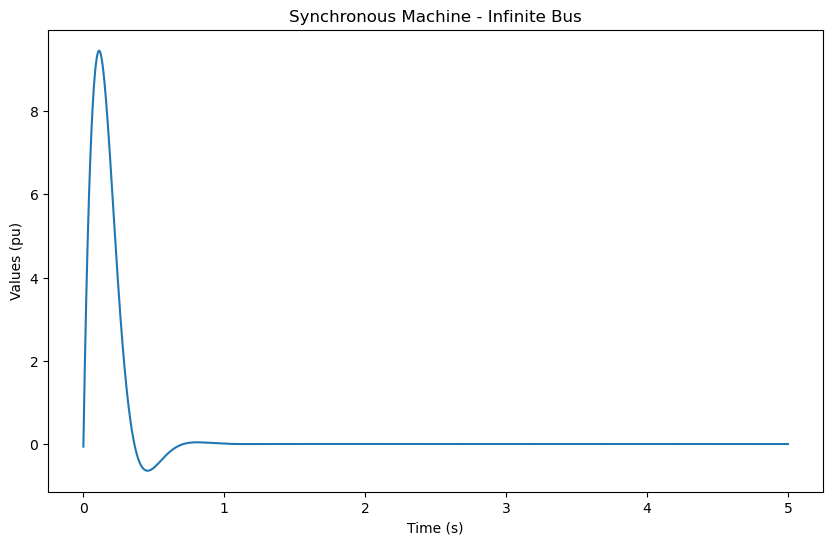

In [6]:
model_num = 0
time = 5
sol=solve_model(time, model_num, modeling_flag="SM", version_flag=True)
plot_sol(sol,1)




In [7]:
from omegaconf import OmegaConf
import wandb
from src.nn.nn_model import Net, Network, PinnA

def define_nn_model(cfg, input_dim, output_dim):
    """
    This function defines the neural network model
    """
    if cfg.nn.type == "StaticNN":
        model = Net(input_dim, cfg.nn.hidden_dim, output_dim)
    elif cfg.nn.type == "DynamicNN" or cfg.nn.type == "PinnB" or cfg.nn.type == "PinnA":
        model = Network(input_dim, cfg.nn.hidden_dim, output_dim, cfg.nn.hidden_layers)
    elif cfg.nn.type == "PinnAA":
        model = PinnA(input_dim, cfg.nn.hidden_dim, output_dim, cfg.nn.hidden_layers)
    else:
        raise ValueError("Invalid nn type specified in the configuration.")
    return model


def load_model(model, cfg, name=None):
    """
    Load neural network model weights from the model_dir.

    Args:
        name (str): name of the model
    """
    # Load model from the model_dir
    model_dir = cfg.dirs.model_dir
    if not os.path.exists(model_dir) or len(os.listdir(model_dir)) == 0:
        raise Exception("No model found in the model_dir, please correct path and name of the model from the bucket first")
    if name is None:
        # Find first model in the model_dir
        name = os.listdir(model_dir)[0]
        if name == '.gitkeep':
            if len(os.listdir(model_dir)) == 1:
                raise Exception("No model found in the model_dir, please correct path and name of the model from the bucket first")
            name = os.listdir(model_dir)[1]
        print("Load model:", name)
    model_path = os.path.join(model_dir, name)
    if not os.path.exists(model_path):
        raise Exception("No model found in the model_dir, please correct path and name of the model from the bucket first")
    model.load_state_dict(torch.load(model_path))
    return None

In [8]:
def data_input_target_limited(solution, time_limit):
    """
    Convert the loaded data into input and target data and limit the time to time_limit.

    Args:
        data (list): The loaded data.
    
    Returns:
        x_train_list (torch.Tensor): The input data.
        y_train_list (torch.Tensor): The target data.
    """
    dataset = []
    for i in range(len(solution)):
        r = [solution[i].t]  # append time to directory
        for j in range(len(solution[i].y)):
            r.append(solution[i].y[j])  # append the solution at each time step
        dataset.append(r)
    x_train_list = torch.tensor(())
    y_train_list = torch.tensor(())
    for training_sample in dataset:
        training_sample = torch.tensor(training_sample, dtype=torch.float32) # convert the trajectory to tensor
        y_train = training_sample[1:].T.clone().detach().requires_grad_(True) # target data
        training_sample_l = training_sample.T
        training_sample_l = training_sample_l[training_sample_l[:,0]<=time_limit].T # limit the time to time_limit
        y_train = training_sample_l[1:].T.clone().detach()
        x_train = training_sample_l.T
        x_train[:,1:]=x_train[0][1:]
        #discrard the first row of x_train and y_train as they are the same
        #x_train = x_train[1:]
        #y_train = y_train[1:]
        x_train = x_train.clone().detach().requires_grad_(True)
        x_train_list = torch.cat((x_train_list, x_train), 0)
        y_train_list = torch.cat((y_train_list, y_train), 0)
    return x_train_list, y_train_list

def forward_pass_b(model,x_train):
    """
    Perform a forward pass of the model.

    Args:
        model (torch.nn.Module): The neural network model.
        x_train (torch.Tensor): The input data.
    
    Returns:
        y_pred (torch.Tensor): The predicted target data.
    """
    y_pred = model(x_train)
    no_time = x_train[:,1:]
    return no_time+y_pred

def forward_pass_a(model,x_train):
    """
    Perform a forward pass of the model.

    Args:
        model (torch.nn.Module): The neural network model.
        x_train (torch.Tensor): The input data.
    
    Returns:
        y_pred (torch.Tensor): The predicted target data.
    """
    y_pred = model(x_train)
    time = x_train[:,0].unsqueeze(1) # get the time column
    no_time = x_train[:,1:]
    return no_time+time*y_pred


def predict(name, type, x_train_list,cfg):
    cfg.nn.type = type
    input_dim = x_train_list.shape[1]
    output_dim = x_train_list.shape[1]-1
    model = define_nn_model(cfg, input_dim, output_dim)
    load_model(model, cfg, name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if type == "PinnA":
        y_pred = forward_pass_a(model,x_train_list)
    elif type == "PinnB":
        y_pred = forward_pass_b(model,x_train_list)
    else:
        y_pred = model.forward(x_train_list)
    return y_pred.detach().cpu().numpy()

def predict_with_saliency_map_one(name, type, x_train_list,cfg):
    cfg.nn.type = type
    x_train_list = x_train_list[0].unsqueeze(0).clone().detach().requires_grad_(True)   
    print(x_train_list.shape)
    input_dim = x_train_list.shape[1]
    output_dim = x_train_list.shape[1]-1
    model = define_nn_model(cfg, input_dim, output_dim)
    load_model(model, cfg, name)
    model.zero_grad()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if type == "PinnA":
        y_pred = forward_pass_a(model,x_train_list)
    elif type == "PinnB":
        y_pred = forward_pass_b(model,x_train_list)
    else:
        y_pred = model.forward(x_train_list)

    # Initialize a list to store saliency maps for each output
    saliency_maps = []

    # Compute gradients for each output
    for i in range(y_pred.shape[1]):
        model.zero_grad()
        output_to_explain = y_pred[0, i]
        output_to_explain.backward(retain_graph=True)
        saliency = x_train_list.grad.data.abs().cpu().numpy()  # Taking absolute value of gradients
        saliency_maps.append(saliency)
    print(saliency)
    # Visualize the saliency maps
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i in range(len(saliency_maps)):
        axes[i].bar(['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'], saliency_maps[i][0])
        axes[i].set_xlabel('Input features')
        axes[i].set_ylabel('Saliency')
        axes[i].set_title(f'Saliency Map for Output {i + 1}')

    plt.tight_layout()
    return y_pred.detach().cpu().numpy()


def predict_with_saliency_map(name, type, x_train_list,cfg):
    cfg.nn.type = type
    print(x_train_list.shape)
    x_train_list = x_train_list.clone().detach().requires_grad_(True)  
    input_dim = x_train_list.shape[1]
    output_dim = x_train_list.shape[1]-1
    model = define_nn_model(cfg, input_dim, output_dim)
    load_model(model, cfg, name)
    model.zero_grad()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if type == "PinnA":
        y_pred = forward_pass_a(model,x_train_list)
    elif type == "PinnB":
        y_pred = forward_pass_b(model,x_train_list)
    else:
        y_pred = model.forward(x_train_list)

    cumulative_saliencies = [torch.zeros(x_train_list.shape[1:], device=device) for _ in range(4)]
    average_saliencies = [torch.zeros(x_train_list.shape[1:], device=device) for _ in range(4)]
    for i in range(y_pred.shape[1]):
        model.zero_grad()
        output_to_explain = y_pred[:, i].sum()  # Sum over the time steps for each output dimension
        output_to_explain.backward(retain_graph=True)
        saliency = x_train_list.grad.data.abs()  # Taking absolute value of gradients
        cumulative_saliencies[i] += saliency.sum(dim=0)
        average_saliencies[i] += saliency.mean(dim=0)
    # Convert cumulative saliencies to numpy for plotting
    cumulative_saliencies = [saliency.cpu().numpy() for saliency in cumulative_saliencies]
    average_saliencies = [saliency.cpu().numpy() for saliency in average_saliencies]
    # Aggregate the cumulative saliency across all time steps for each output

    # Plot the cumulative saliency map for each output
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for i, saliency_map in enumerate(average_saliencies):
        ax = axes[i // 2, i % 2]
        ax.bar(['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'], saliency_map)
        ax.set_xlabel('Input features')
        ax.set_ylabel('Cumulative Saliency')
        ax.set_title(f'Cumulative Saliency Map for Output {i + 1}')

    plt.tight_layout()
    plt.show()
    return average_saliencies


C:\Users\Giannis\AppData\Local\Temp\ipykernel_29604\2542540788.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  training_sample = torch.tensor(training_sample, dtype=torch.float32) # convert the trajectory to tensor


torch.Size([1000, 5])


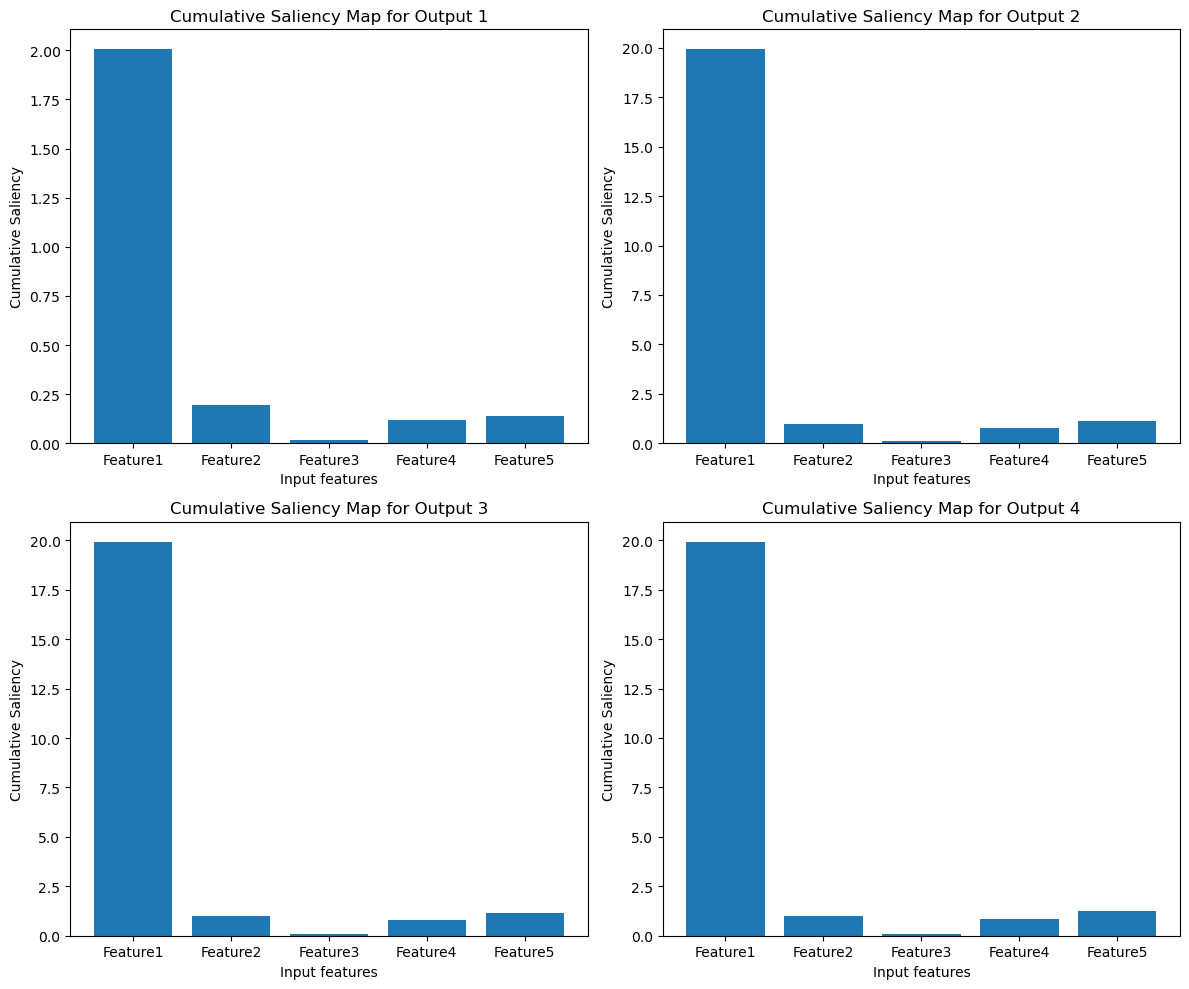

torch.Size([1000, 5])


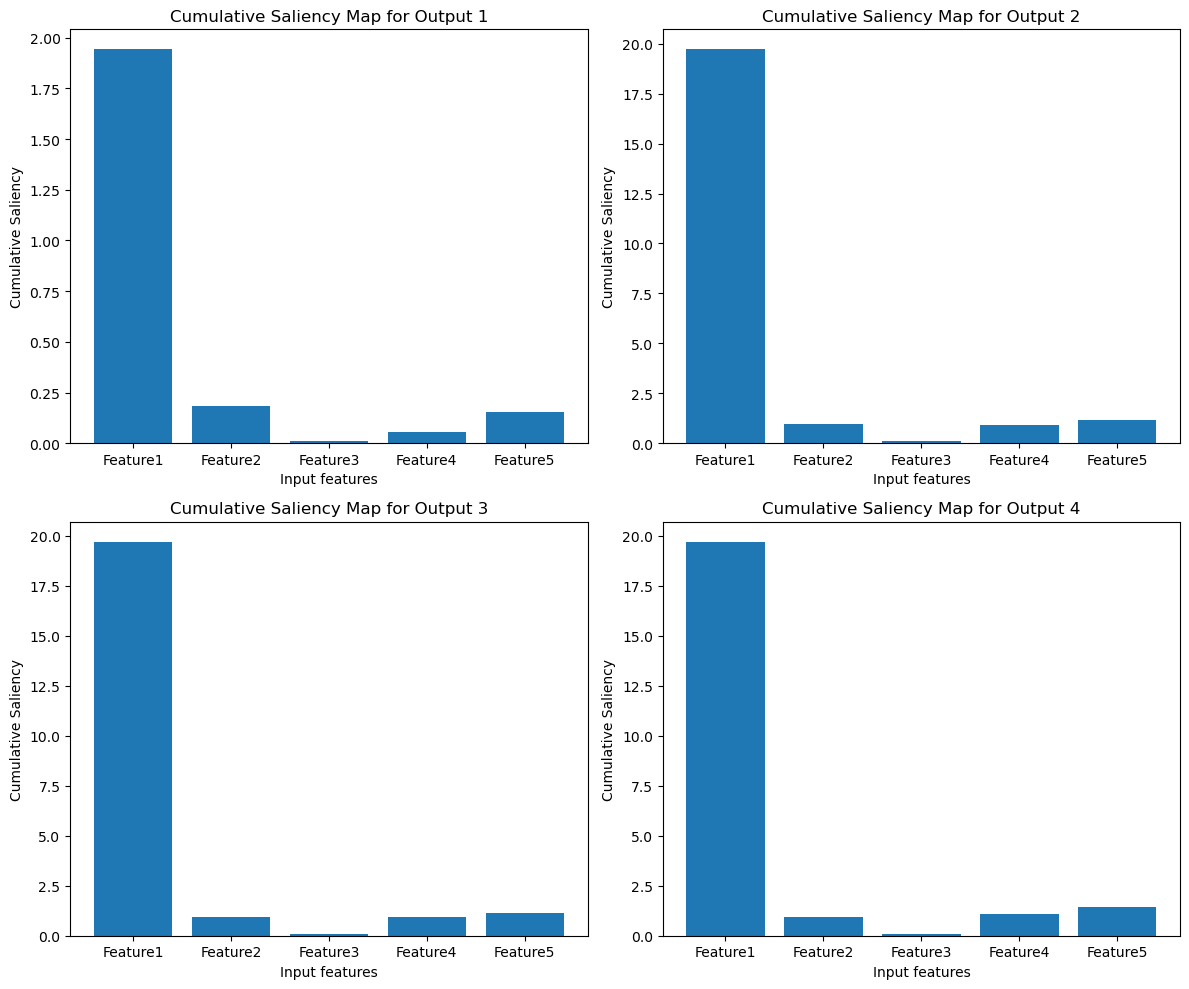

torch.Size([1000, 5])


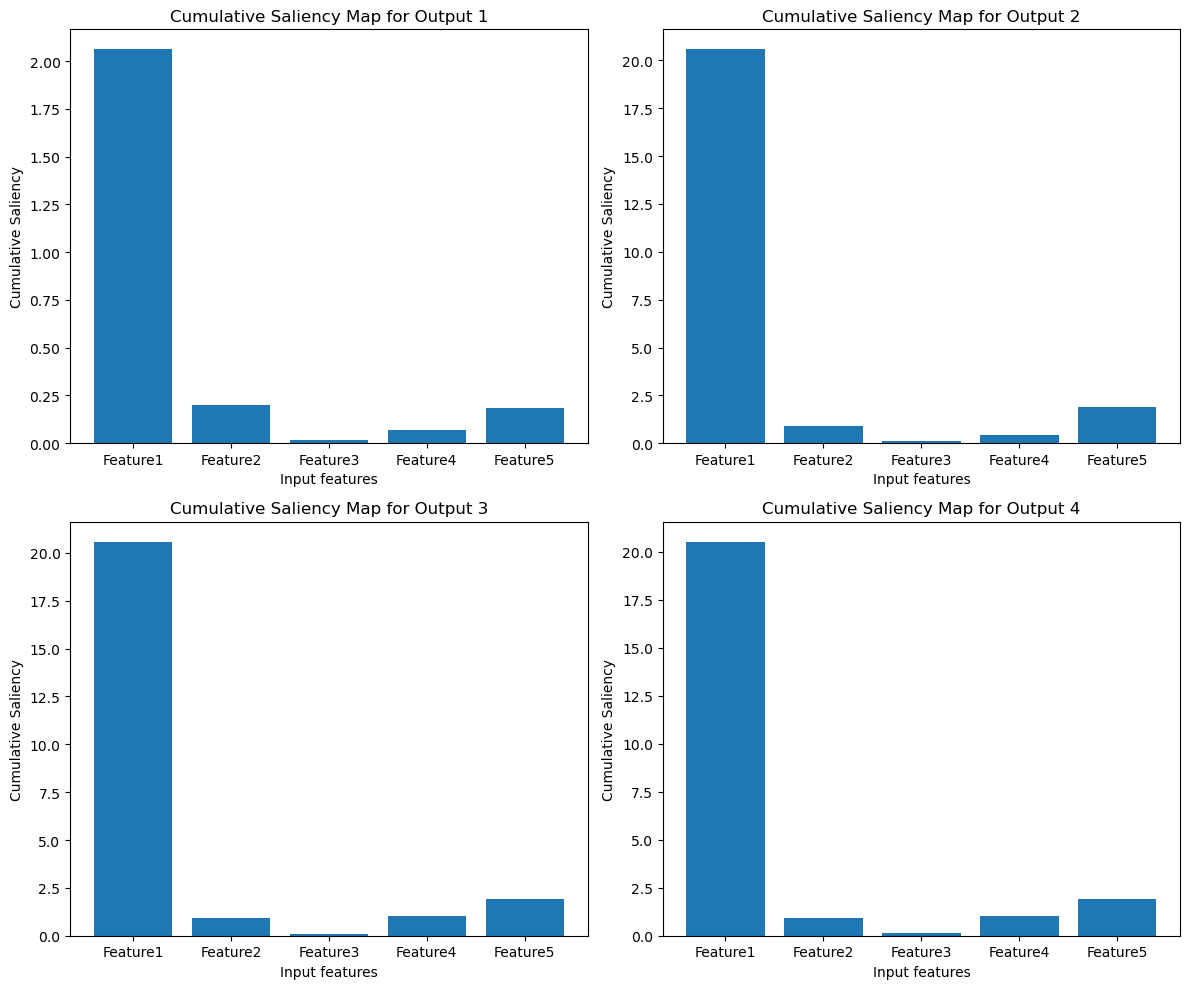

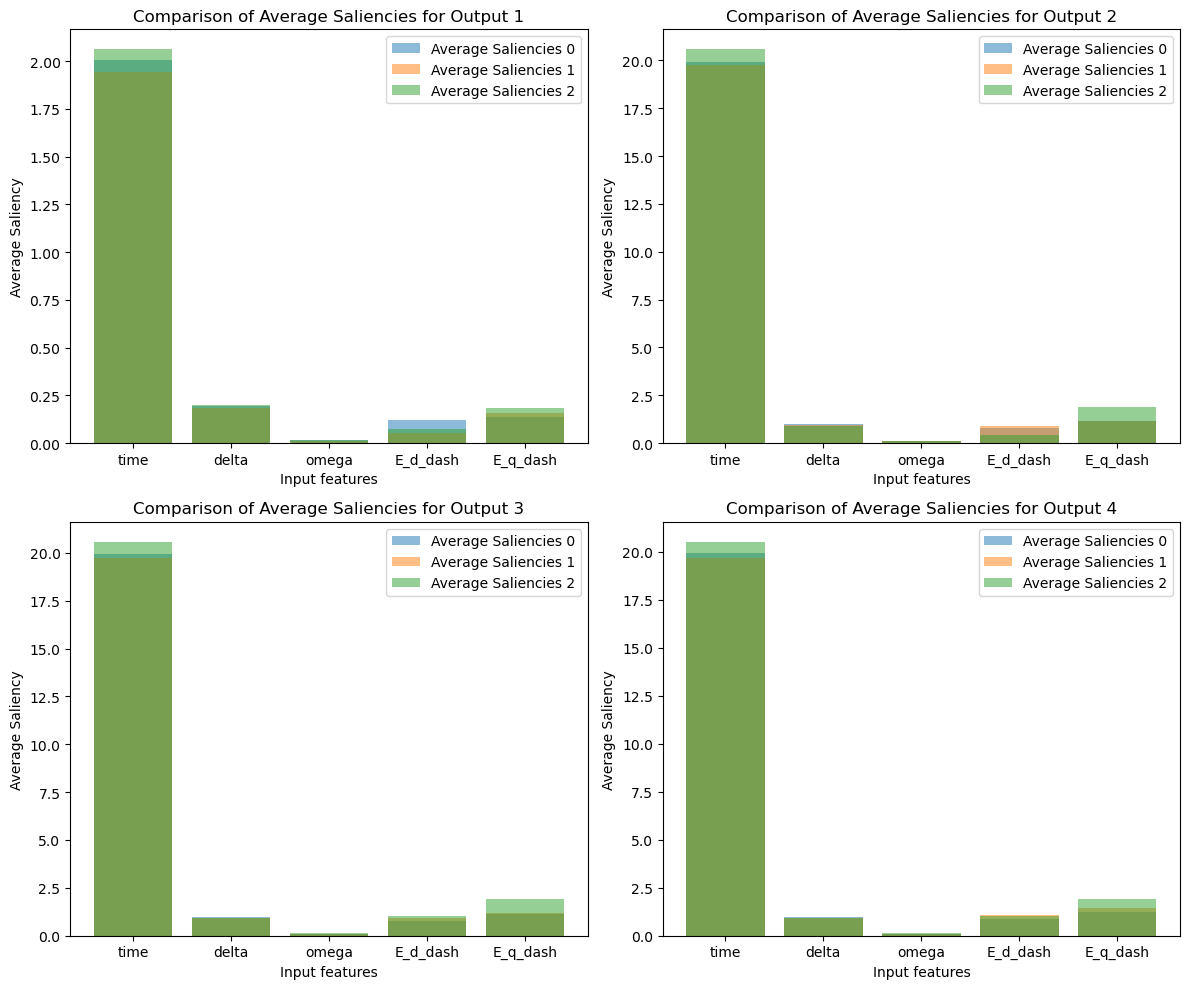

In [9]:
cfg = OmegaConf.load("src/conf/setup_dataset_nn.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train_list, y_train_list = data_input_target_limited(sol, 1)
x_train_list = x_train_list.to(device)
y_train_list = y_train_list.to(device)
y_train_list = y_train_list.detach().cpu().numpy()
name_NN_data = "data\SMDynamicNN_1_500_28572_26316_10000_1_0_0_Sam.pth"
average_saliencies0 = predict_with_saliency_map(name_NN_data, "DynamicNN", x_train_list, cfg)

nameNN = "data_dt_pinn\SMDynamicNN_1_500_13794_38462_10000_1_0.0001_1e-05_Sam.pth"
average_saliencies1 = predict_with_saliency_map(nameNN, "DynamicNN", x_train_list, cfg)

nameA = "data_dt_pinn\SMPinnAA_1_500_28572_26316_10000_1_0.0001_1e-05_Sam.pth"
average_saliencies2 = predict_with_saliency_map(nameA, "PinnA", x_train_list, cfg)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i in range(len(average_saliencies0)):
    ax = axes[i // 2, i % 2]
    x_labels = ['time','delta', 'omega', 'E_d_dash', 'E_q_dash']
    ax.bar(x_labels, average_saliencies0[i], label='Average Saliencies 0', alpha=0.5)
    ax.bar(x_labels, average_saliencies1[i], label='Average Saliencies 1', alpha=0.5)
    ax.bar(x_labels, average_saliencies2[i], label='Average Saliencies 2', alpha=0.5)
    ax.set_xlabel('Input features')
    ax.set_ylabel('Average Saliency')
    ax.set_title(f'Comparison of Average Saliencies for Output {i + 1}')
    ax.legend()
plt.tight_layout()
plt.show()


tensor(0.0110) nn
tensor(0.0086) a
tensor(0.0120) a2
tensor(0.0204) nn
tensor(0.0222) a
tensor(0.0258) a2


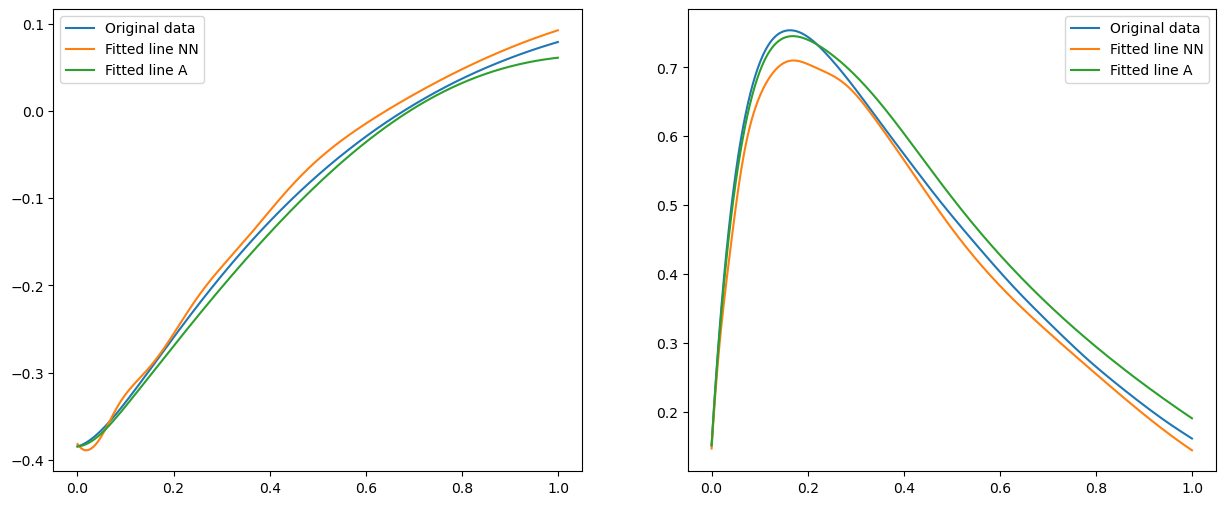

tensor(0.0023) nn
tensor(0.0007) a
tensor(0.0023) a2
tensor(0.0033) nn
tensor(0.0041) a
tensor(0.0034) a2


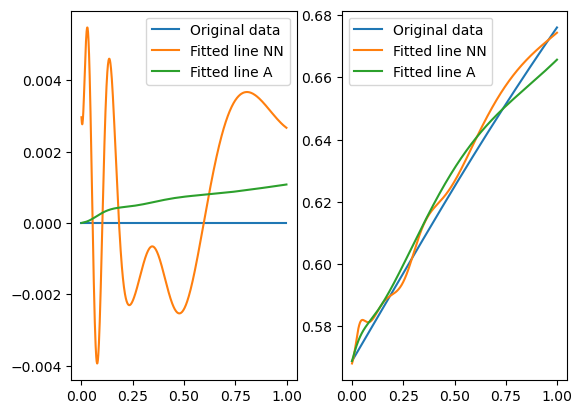

In [11]:

cfg = OmegaConf.load("src/conf/setup_dataset_nn.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train_list, y_train_list = data_input_target_limited(sol, 1)
x_train_list = x_train_list.to(device)
y_train_list = y_train_list.to(device)
y_train_list = y_train_list.detach().cpu().numpy()

nameNN = "delete\GiannisSMDynamicNN_1_10000_16000_266667_3334_1_0.0001_1e-05.pth"
y_predNN = predict(nameNN, "DynamicNN", x_train_list, cfg)

nameA = "data_dt_pinn\SMPinnAA_1_500_28572_26316_10000_1_0.0001_1e-05_Sam.pth"
y_predA = predict(nameA, "PinnA", x_train_list, cfg)

nameA2 = "delete\GiannisSMPinnA_1_20000_16000_266667_3334_1_0.0001_1e-05.pth"
y_predA2 = predict(nameA2, "PinnA", x_train_list, cfg)


x_train_list = x_train_list.detach().cpu().numpy()
plt.figure(figsize=(15, 6))

xp = torch.linspace(0, 1, 50)
for i in range(y_train_list.shape[1]):
    plt.subplot(1, 2, i % 2 + 1)  # Create subplots, alternating between two columns

    plt.plot(x_train_list[:,0], y_train_list[:, i],  label='Original data')
    plt.plot(x_train_list[:,0], y_predNN[:, i],  label='Fitted line NN')
    plt.plot(x_train_list[:,0], y_predA[:, i],  label='Fitted line A')
    #plt.plot(x_train_list[:,0], y_predA2[:, i],  label='Fitted line A2')
    #plt.plot(x_train_list[:,0], y_predA3[:, i],  label='Fitted line A3')
    #plot as bullets fifty points of x_train_list 
    #plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, label='Physics loss training locations')
    print(torch.mean(torch.abs(torch.tensor(y_train_list[:, i]) - torch.tensor(y_predNN[:, i]))), "nn")
    print(torch.mean(torch.abs(torch.tensor(y_train_list[:, i]) - torch.tensor(y_predA[:, i]))), "a")
    print(torch.mean(torch.abs(torch.tensor(y_train_list[:, i]) - torch.tensor(y_predA2[:, i]))), "a2")

    #plt.plot(x_train_list[:,0], y_predAA[:, i],  label='Fitted line AA')
    plt.legend()
    if i % 2 != 0:
        plt.show()  # Show the plot after every two iterations



0.03161913610455158

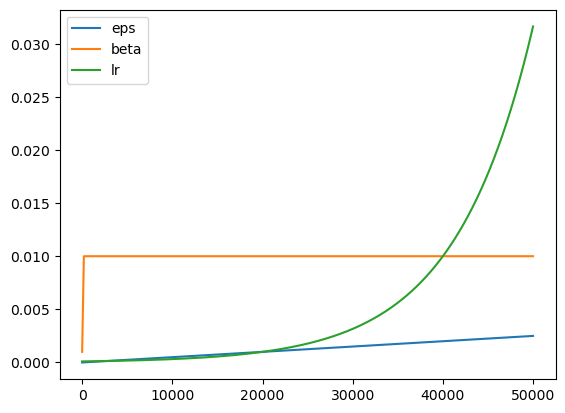

In [34]:
import matplotlib.pyplot as plt
epochs_to_tenfold = 50
eps = []
beta = []
lr= []
#epoch_factor = torch.tensor(10.0 ** (epoch / epochs_to_tenfold))
for epoch in range(500):
    eps.append(min(0.01, 0.001 * epoch / epochs_to_tenfold))
    beta.append(min(0.01,  0.001 + epoch / epochs_to_tenfold))
    lr.append(min(0.05,0.00001 * 10**(epoch / epochs_to_tenfold)))
    
plt.plot(eps, label='eps')
plt.plot(beta, label='beta')
plt.plot(lr, label='lr')
plt.legend()
lr[-1]

All the combinations

Set True only one flag each time:

not_ib_flag = True ->2 axis model\
avr_flag    = True ->2 axis model with AVR\
gov_flag    = True ->2 axis model with AVR and Governor\
all False   -> Infinite bus model

In [16]:
solution = {}
models = ["SM_IB","SM", "SM_AVR", "SM_AVR_GOV"]
for j in range(len(models)):
    for i in range(7):
        #print("Selected Model: ",i)
        #append the solution solve_model(i, not_ib_flag,avr_flag,gov_flag)
        solution[j,i]=solve_model(15, i,models[j],version_flag= True)
        

Change  number that has comment to plot the solution for different initial conditions

Model:  0


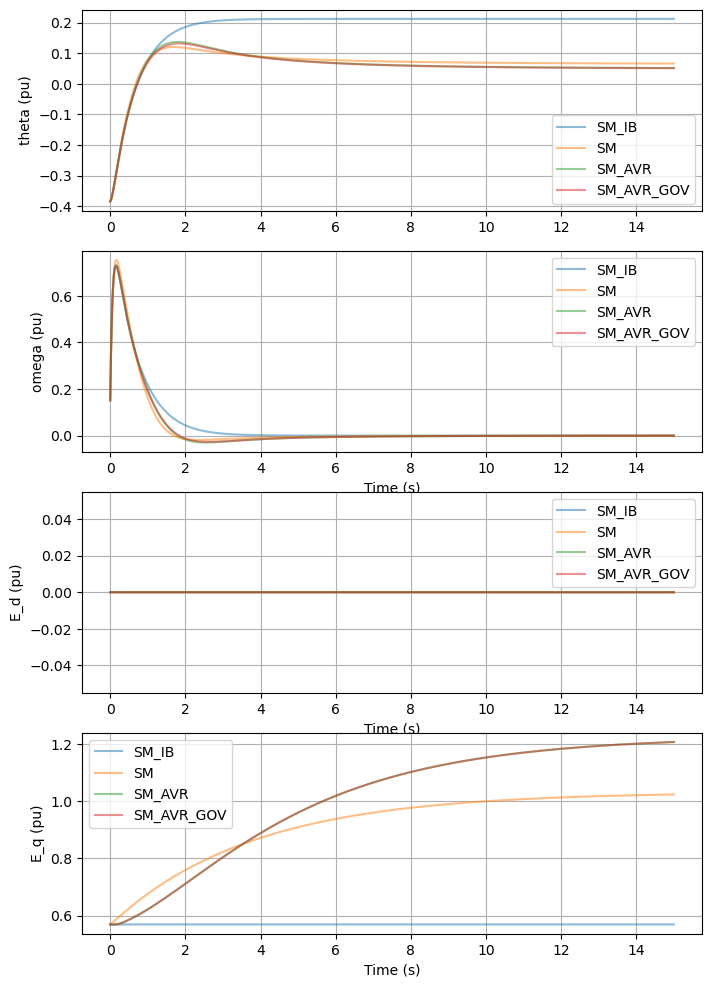

Model:  1


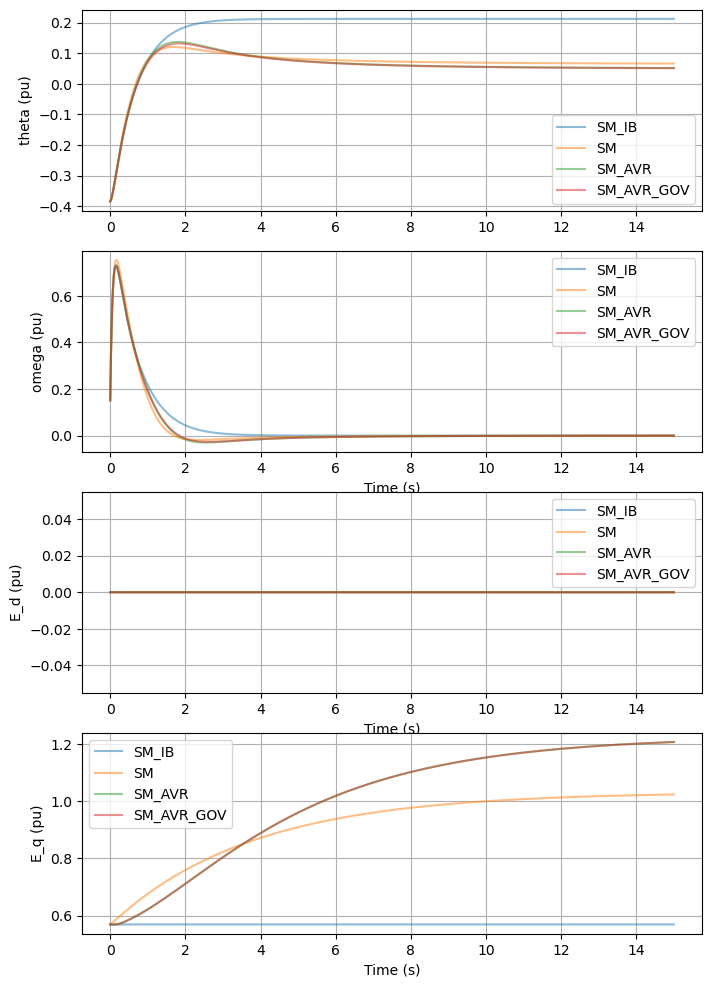

Model:  2


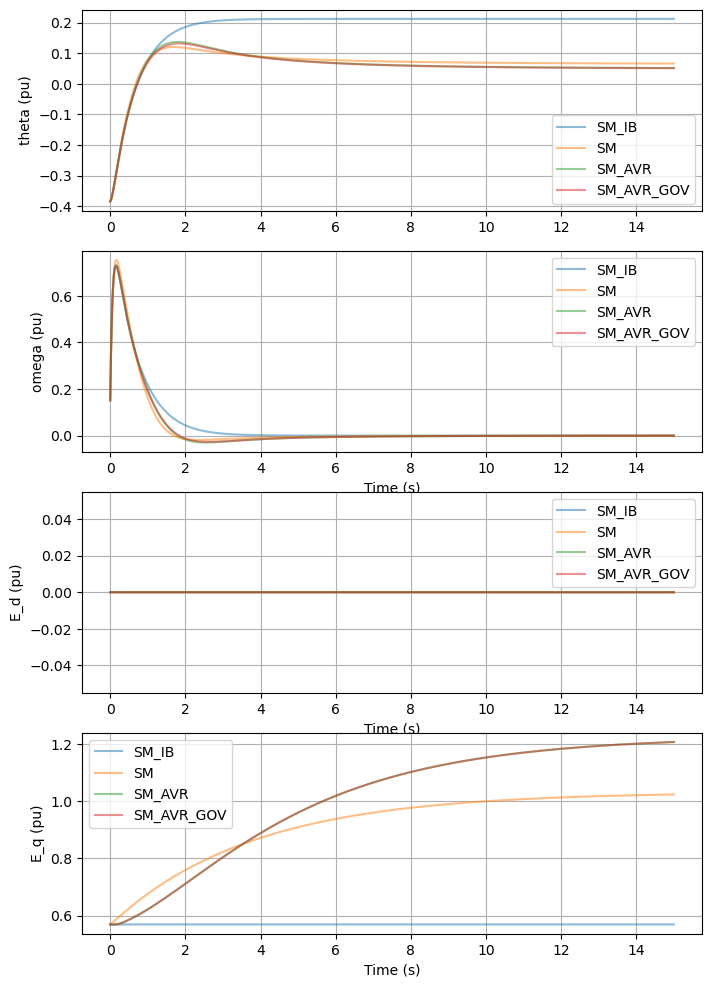

Model:  3


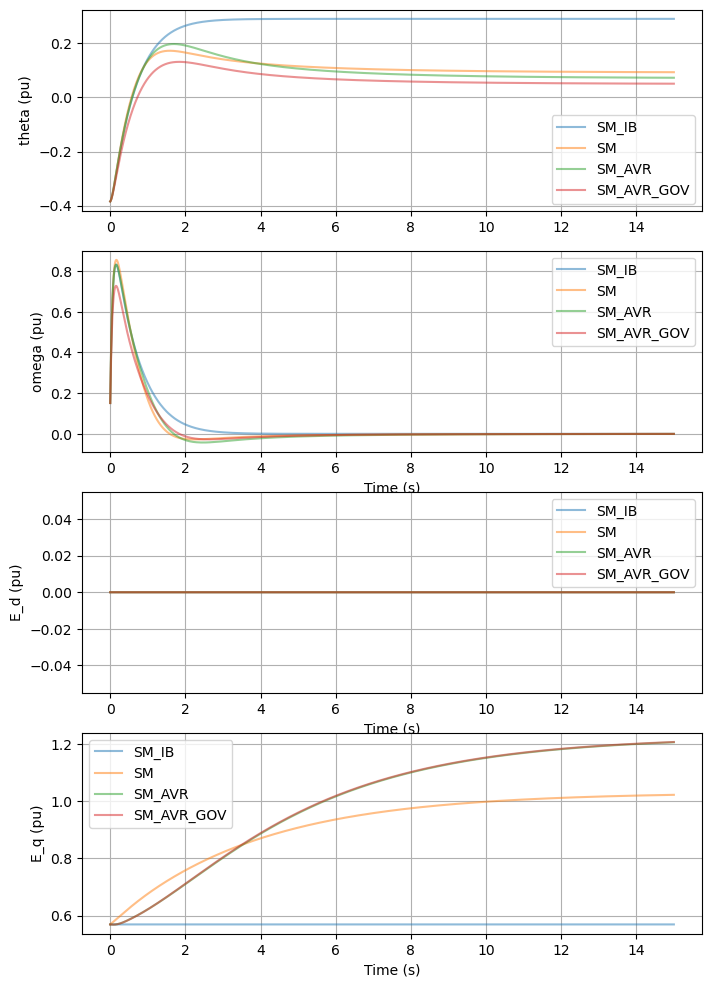

Model:  4


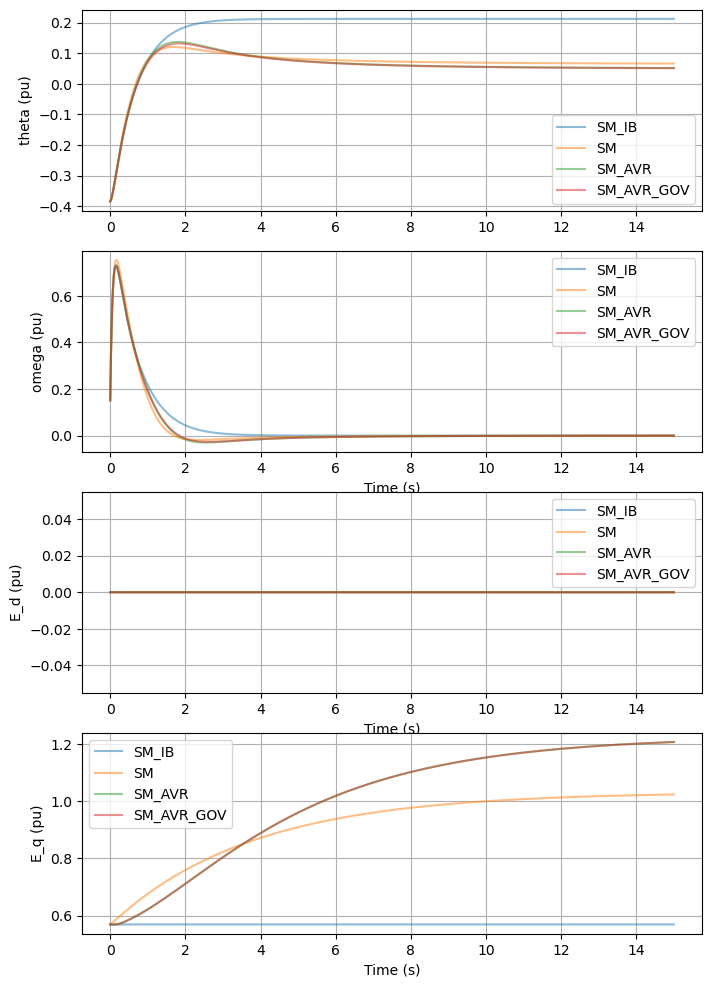

Model:  5


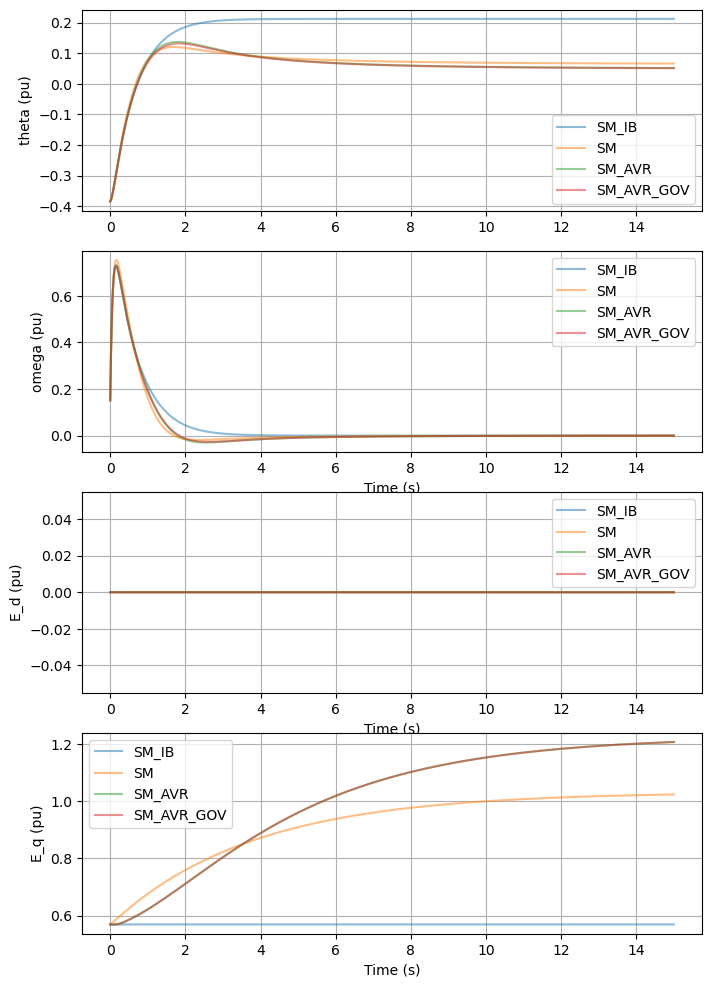

Model:  6


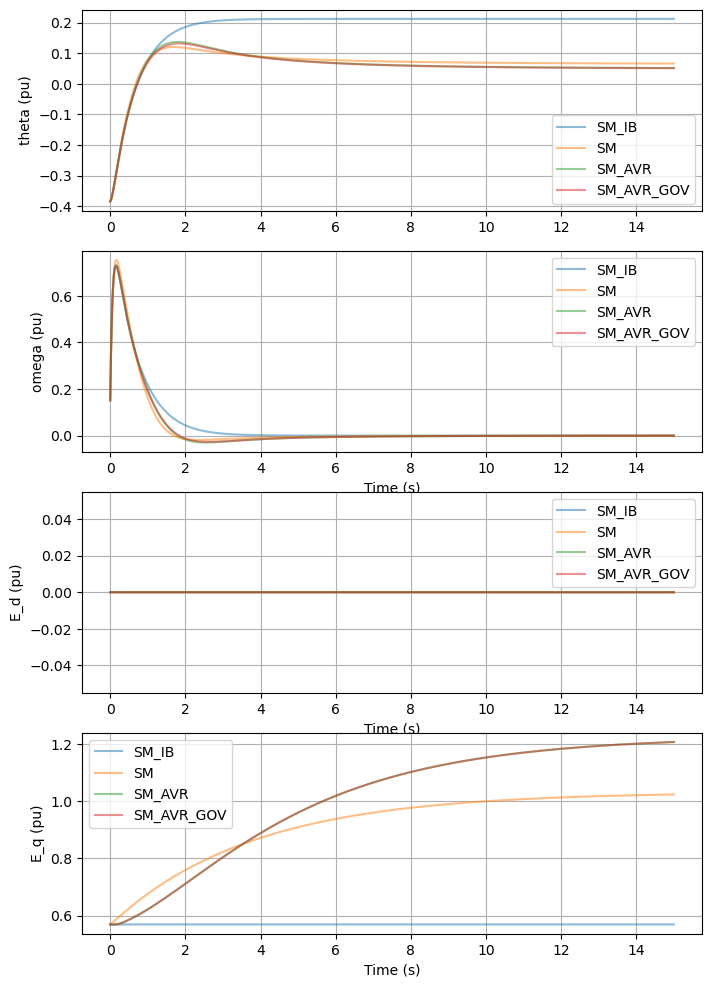

In [23]:
# Plotting the solution with gridspec
def plotting_solution_gridspec_all(solution):
    flag = ["SM_IB","SM", "SM_AVR", "SM_AVR_GOV"]
    for i in range(7):
        print("Model: ",i)
        fig, axs = plt.subplots(4, 1, figsize=(8, 12))
        for j in range(len(flag)):
            sol=solution[j,i][0]  #Change this number to check different initial conditions
            axs[0].plot(sol.t, sol.y[0], label=flag[j],alpha=0.5)
            axs[0].set_ylabel('theta (pu)')
            axs[0].legend()
            axs[0].grid(True)
            
            axs[1].plot(sol.t, sol.y[1], label=flag[j],alpha=0.5)
            axs[1].set_xlabel('Time (s)')
            axs[1].set_ylabel('omega (pu)')
            axs[1].legend()
            axs[1].grid(True)
            
            axs[2].plot(sol.t, sol.y[2], label=flag[j],alpha=0.5)
            axs[2].set_xlabel('Time (s)')
            axs[2].set_ylabel('E_d (pu)')
            axs[2].legend()
            axs[2].grid(True)
            
            axs[3].plot(sol.t, sol.y[3], label=flag[j],alpha=0.5)
            axs[3].set_xlabel('Time (s)')
            axs[3].set_ylabel('E_q (pu)')
            axs[3].legend()
            axs[3].grid(True)
        
        plt.show()
    return None

#solution[j,i]
plotting_solution_gridspec_all(solution)

Plot the various models with initial state:

    delta0=0.3
    omega0=0.2
    E_d_dash0=0
    E_q_dash0=1

Model:  0


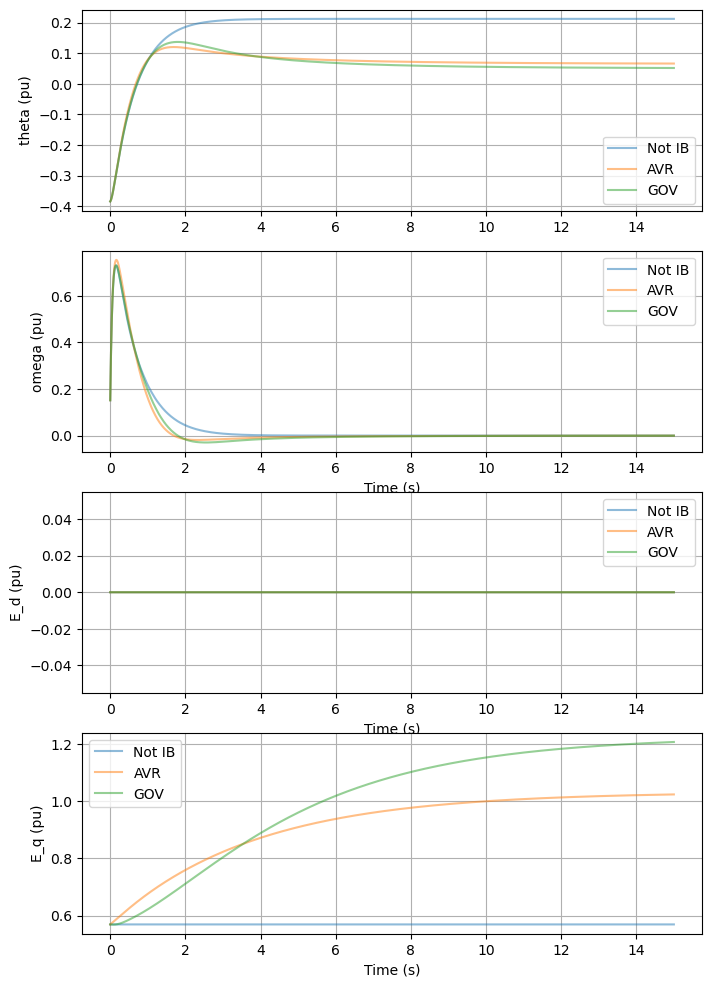

Model:  1


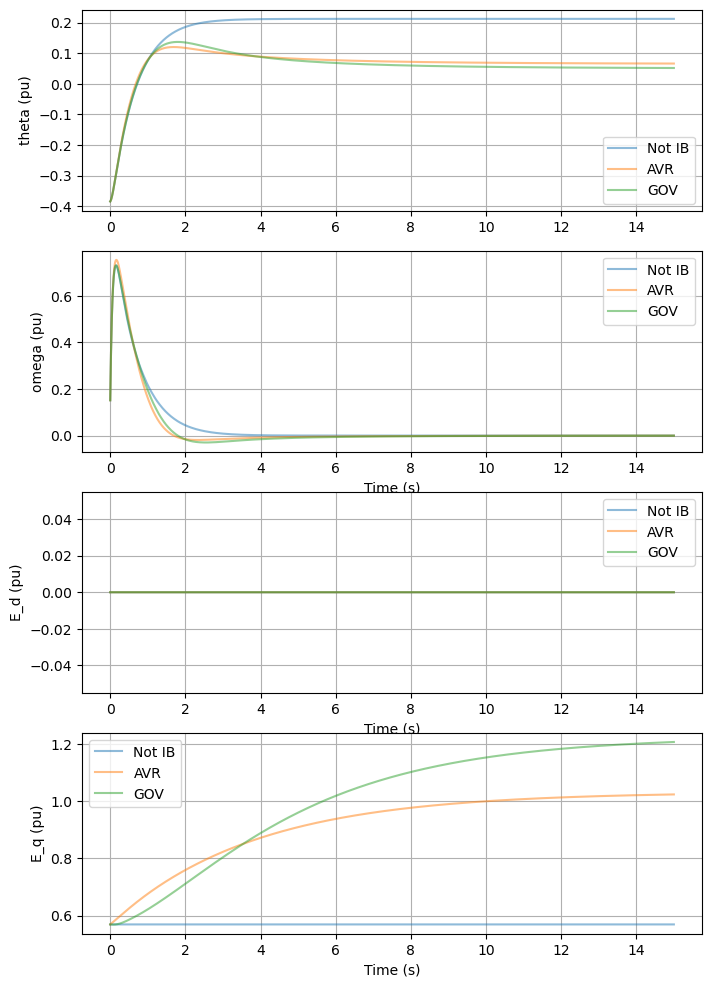

Model:  2


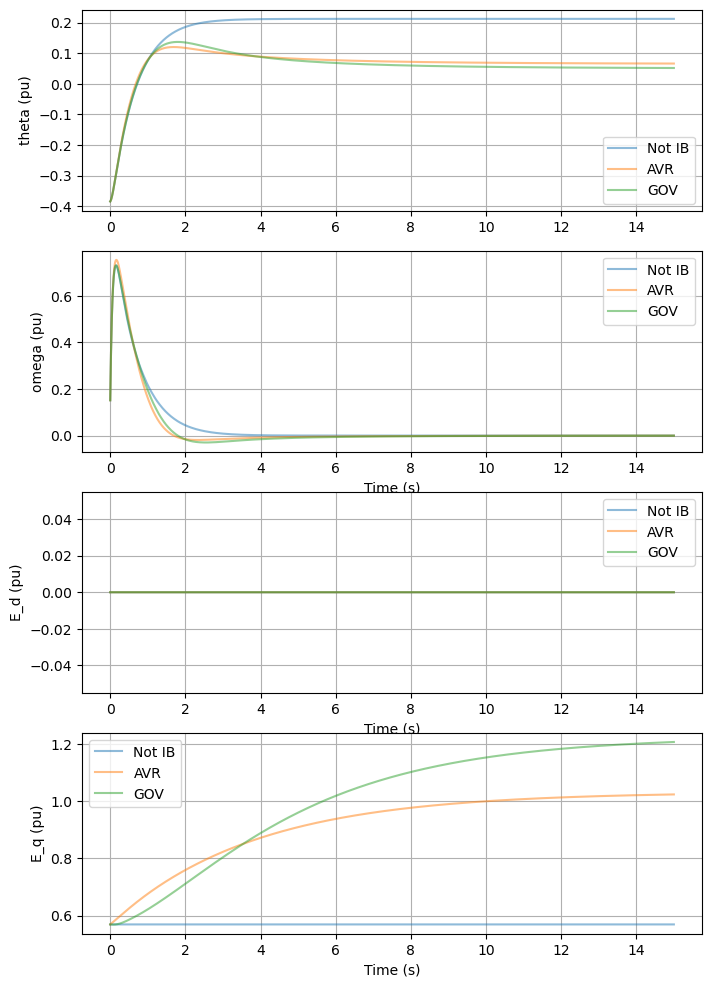

Model:  3


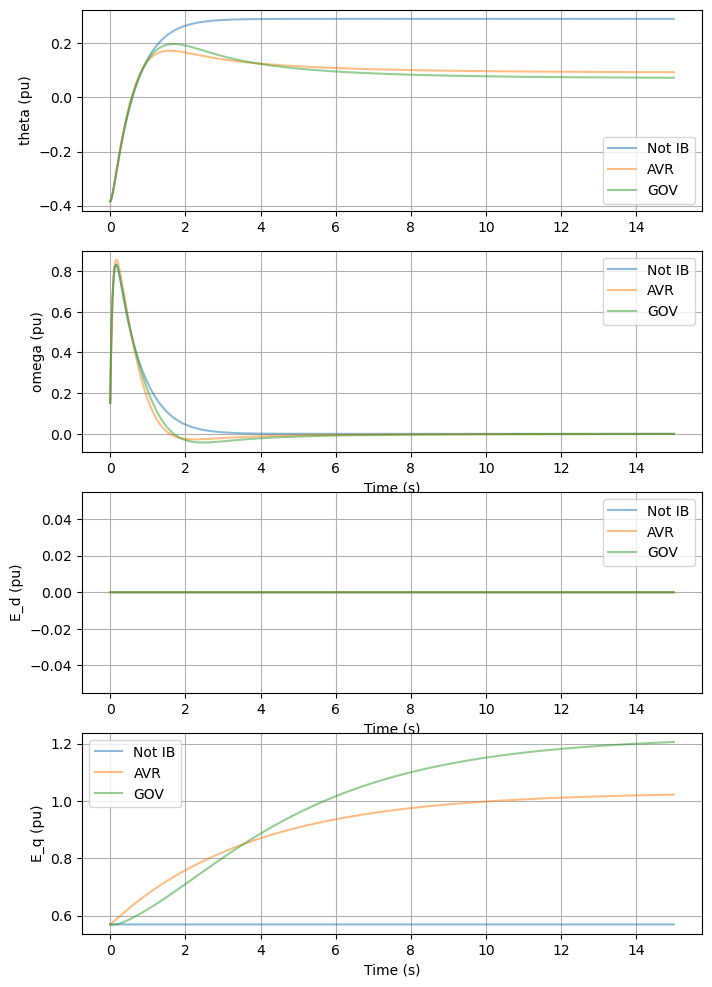

Model:  4


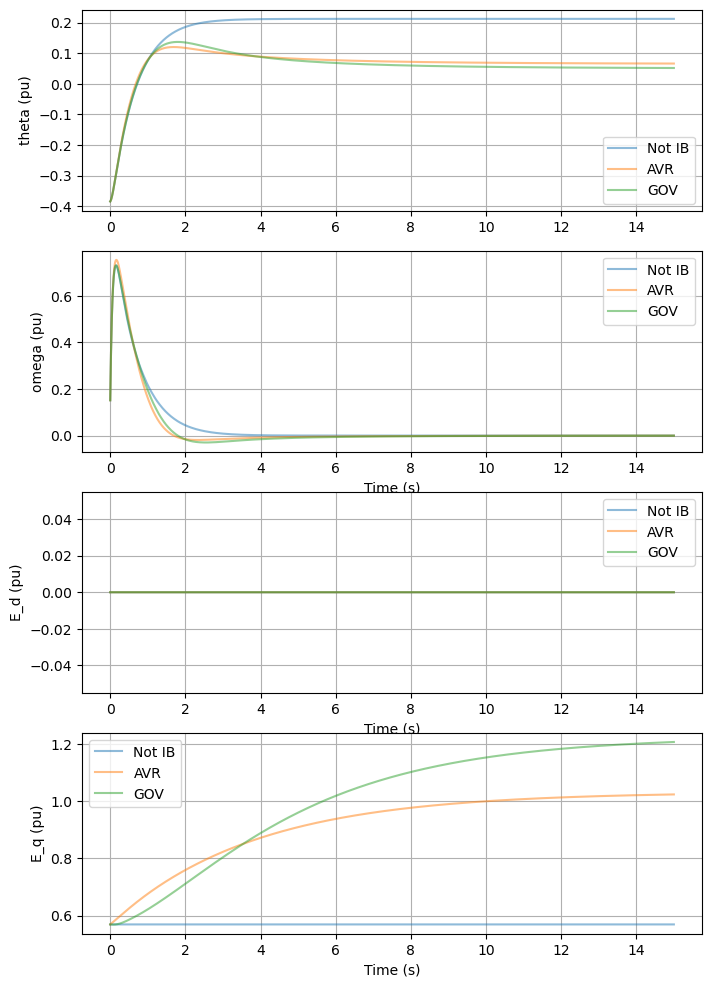

Model:  5


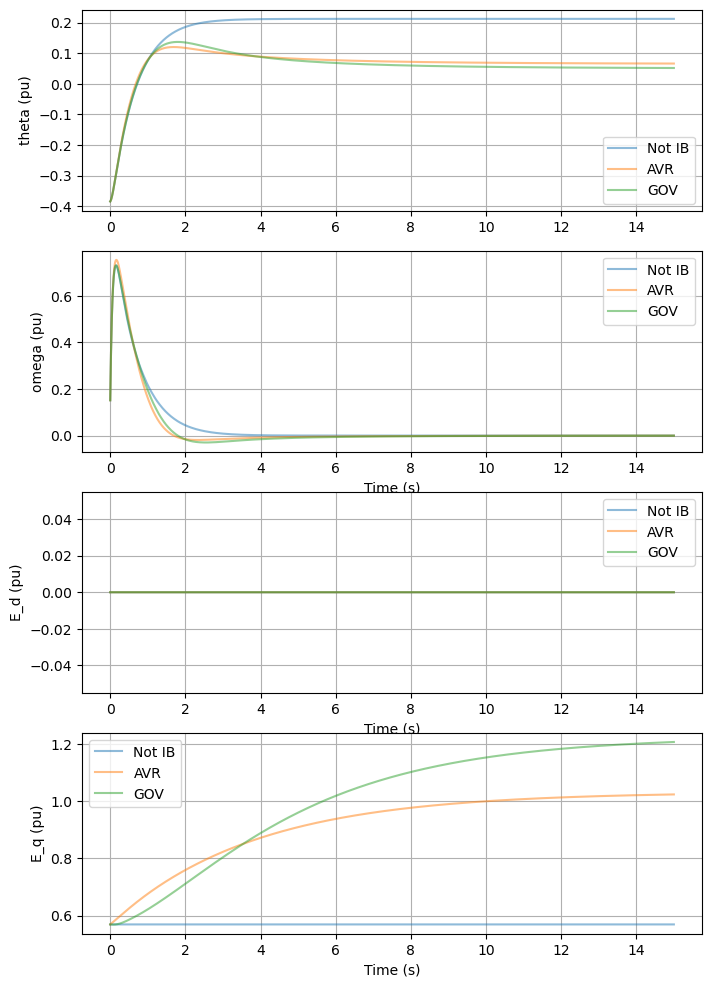

Model:  6


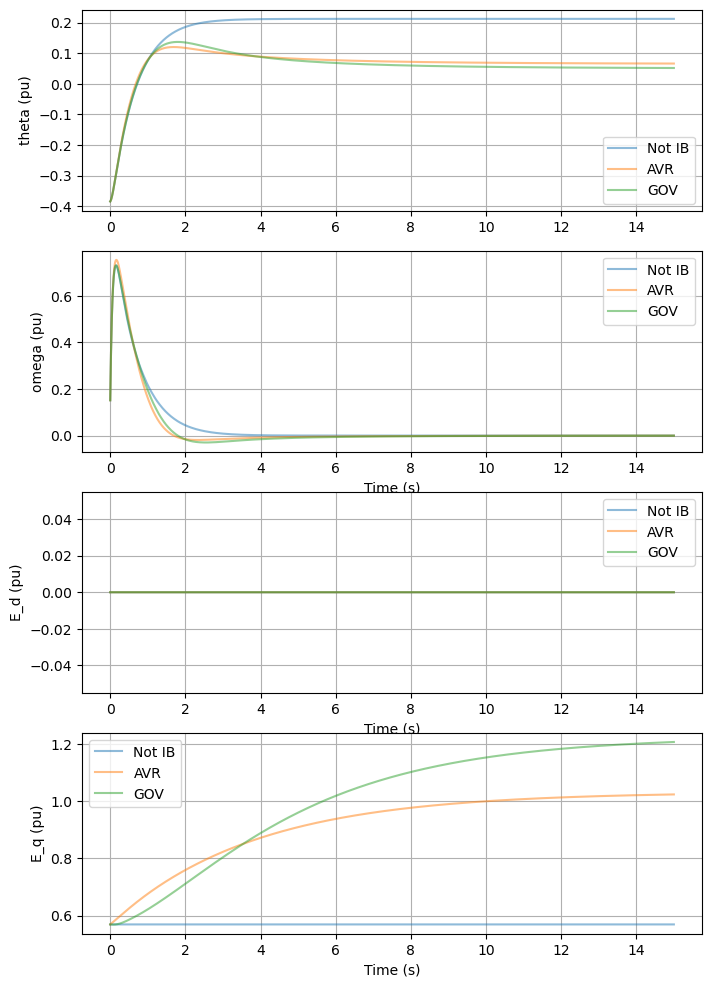

In [18]:
# Plotting the solution with gridspec
def plotting_solution_gridspec_all(solution):
    flag = ['Not IB', 'AVR', 'GOV']
    for i in range(7):
        print("Model: ",i)
        fig, axs = plt.subplots(4, 1, figsize=(8, 12))
        for j in range(3):
            sol=solution[j,i][0]
            axs[0].plot(sol.t, sol.y[0], label=flag[j],alpha=0.5)
            axs[0].set_ylabel('theta (pu)')
            axs[0].legend()
            axs[0].grid(True)
            
            axs[1].plot(sol.t, sol.y[1], label=flag[j],alpha=0.5)
            axs[1].set_xlabel('Time (s)')
            axs[1].set_ylabel('omega (pu)')
            axs[1].legend()
            axs[1].grid(True)
            
            axs[2].plot(sol.t, sol.y[2], label=flag[j],alpha=0.5)
            axs[2].set_xlabel('Time (s)')
            axs[2].set_ylabel('E_d (pu)')
            axs[2].legend()
            axs[2].grid(True)
            
            axs[3].plot(sol.t, sol.y[3], label=flag[j],alpha=0.5)
            axs[3].set_xlabel('Time (s)')
            axs[3].set_ylabel('E_q (pu)')
            axs[3].legend()
            axs[3].grid(True)
        
        plt.show()
    return None

#solution[j,i]
plotting_solution_gridspec_all(solution)